In [1]:
from AxonDeepSeg import ads_utils
from AxonDeepSeg.morphometrics.compute_morphometrics import get_axon_morphometrics

import matplotlib.pyplot as plt
import matplotlib.patches as patches
import pandas as pd
import numpy as np

%matplotlib inline

# Myelin segmentation pre-processing
To pre-process the segmentations, we will use the ADS `get_axon_morphometrics()` function with the following flags: `return_border_info` (to get the bounding box coordinates) and `return_instance_seg` (to get the instance map).
We will then use the instance map to subdivide the myelin mask into individual myelin annotations for every axon. In order to prompt SAM, we will additionnally need the bounding boxes and the axon centroids. The outputs of this preprocessing pipeline are:
- Myelin instance map
- Truncated morphometrics file (with bbox and axon centroids)
- Exclusion list (axons with bad instance maps should be excluded from the dataset)

These are the inputs we will be working with:
| Semantic segmentation | Instance segmentation |
|:-:|:-:|
| <img src="https://github.com/brainhack-school2023/collin_project/assets/83031821/d09274af-b062-43c3-815f-a45850e5ef3a"> | <img src="https://github.com/brainhack-school2023/collin_project/assets/83031821/fc04f880-737a-43f4-a5b9-2a764c9f9434"  > |



In [2]:
image = ads_utils.imread('image.png')
axon_mask = ads_utils.imread('image_seg-axon.png')
myelin_mask = ads_utils.imread('image_seg-myelin.png')
morphometrics = pd.read_csv('image_axon_morphometrics.csv', sep=',')
instance_map = ads_utils.imread('image_instance-map.png', bitdepth=16)
print(np.unique((myelin_mask == 255) * instance_map))
print(np.unique(instance_map))
morphometrics.tail()

morph_output = get_axon_morphometrics(
    axon_mask, 
    im_myelin=myelin_mask, 
    pixel_size=0.07,
    return_border_info=True,
    return_instance_seg=True
)
df, instance_seg_im, instance_map = morph_output

[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233
 234 235 236 237 238 239 240 241 242 243 244 245 24

2023-05-29 11:09:43.988 | INFO     | AxonDeepSeg.visualization.colorization:colorize_instance_segmentation:102 - Colorizing 298 instances.


## Example
Let's take axon 10 to illustrate what we will need

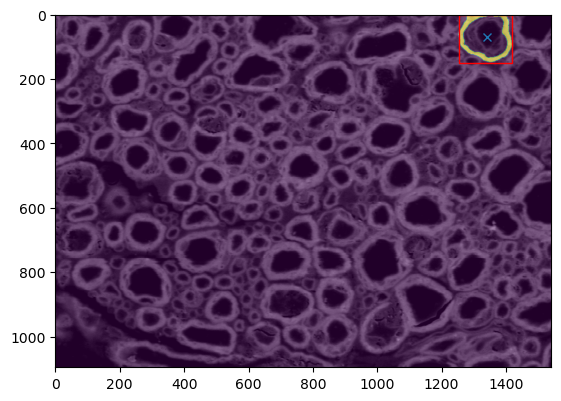

In [3]:
fig, ax = plt.subplots()

# Display the image
ax.imshow(image, cmap='gray')

bboxes = morphometrics.iloc[:, -4:]
min_x, min_y = bboxes.iloc[:, -3], bboxes.iloc[:, -4]
w = bboxes.iloc[:, -1] - bboxes.iloc[:, -3]
h = bboxes.iloc[:, -2] - bboxes.iloc[:, -4]

# Create a rectangle around axon #10
rect = patches.Rectangle(
    (min_x.iloc[10], min_y.iloc[10]),
    w.iloc[10],
    h.iloc[10],
    linewidth=1,
    edgecolor='r',
    facecolor='none'
)
ax.add_patch(rect)

# we can also get the myelin associated with axon #10
# note that the instance map starts at 0 for background
ax.imshow(myelin_mask * (instance_map == 11), alpha=0.5)

# finally, we can get the axon centroid with the (x0, y0) columns
centroids = morphometrics.iloc[:, 1:3]
coords = centroids.iloc[10]
ax.plot([coords[0]], [coords[1]], marker='x')

plt.show()

In [4]:
# create the reduced prompt dataframe
width_heigth = pd.DataFrame({'width': w, 'heigth': h})
prompts_df = pd.concat([centroids.astype('int64'), bboxes, width_heigth], axis=1)
prompts_df.rename(
    columns={
        'bbox_min_y': 'min_y', 
        'bbox_min_x': 'min_x',
        'x0 (px)': 'x0',
        'y0 (px)': 'y0',
    }, 
    inplace=True
)
prompts_df.drop(columns=['bbox_max_y', 'bbox_max_x'], inplace=True)
print(prompts_df.tail())

       x0    y0  min_y  min_x  width  heigth
293  1152  1085   1062   1080    116      34
294  1223  1090   1084   1220     25      11
295  1485  1091   1078   1453     56      18
296   214  1091   1081    202     60      14
297   693  1091   1084    686     10      10


All these functionnalities are automated within the `extract_myelin_map_and_prompts()` function.

In [5]:
import sys
sys.path.append('../scripts')
from preprocessing import extract_myelin_map_and_prompts

mmap, prompts = extract_myelin_map_and_prompts('image_seg-axon.png', 'image_seg-myelin.png', 0.07)
print(prompts.tail())
print(prompts_df.tail())

2023-05-29 11:09:49.687 | INFO     | AxonDeepSeg.visualization.colorization:colorize_instance_segmentation:102 - Colorizing 298 instances.


              x0           y0
0     116.993521     5.280778
1     375.787583    38.270709
2     501.567568     2.648649
3     542.506394    16.260870
4     692.760180    45.261501
..           ...          ...
293  1152.360000  1085.250526
294  1223.500000  1090.736842
295  1485.542254  1091.676056
296   214.500000  1091.312500
297   693.000000  1091.000000

[298 rows x 2 columns]
       x0    y0  min_y  min_x  width  heigth
293  1152  1085   1062   1080    116      34
294  1223  1090   1084   1220     25      11
295  1485  1091   1078   1453     56      18
296   214  1091   1081    202     60      14
297   693  1091   1084    686     10      10
       x0    y0  min_y  min_x  width  heigth
293  1152  1085   1062   1080    116      34
294  1223  1090   1084   1220     25      11
295  1485  1091   1078   1453     56      18
296   214  1091   1081    202     60      14
297   693  1091   1084    686     10      10
